In [1]:
import pandas as pd
import numpy as np

## Чтение данных

In [2]:
batt=pd.read_csv('battles.csv')

In [3]:
train=pd.read_csv('character-predictions.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
S.No                 1946 non-null int64
actual               1946 non-null int64
pred                 1946 non-null int64
alive                1946 non-null float64
plod                 1946 non-null float64
name                 1946 non-null object
title                938 non-null object
male                 1946 non-null int64
culture              677 non-null object
dateOfBirth          433 non-null float64
DateoFdeath          444 non-null float64
mother               21 non-null object
father               26 non-null object
heir                 23 non-null object
house                1519 non-null object
spouse               276 non-null object
book1                1946 non-null int64
book2                1946 non-null int64
book3                1946 non-null int64
book4                1946 non-null int64
book5                1946 non-null int64
isAliveMother        21 non

In [5]:
train.corr()['actual']

S.No                -0.128708
actual               1.000000
pred                 0.359028
alive                0.420795
plod                -0.420795
male                -0.144552
dateOfBirth         -0.086315
DateoFdeath               NaN
book1               -0.147401
book2               -0.067200
book3                0.006693
book4                0.268975
book5                0.032846
isAliveMother       -0.043033
isAliveFather        0.195992
isAliveHeir          0.384900
isAliveSpouse        0.174275
isMarried           -0.050037
isNoble             -0.042211
age                  0.087712
numDeadRelations    -0.192444
boolDeadRelations   -0.193736
isPopular           -0.153860
popularity          -0.183174
isAlive              0.997291
Name: actual, dtype: float64

# Обработка признаков

Иcключим столбики, где очень много пропущенных значений. Не очевидно, что есть целевая переменная, поэтому выберем одну из тех, что очень на нее похоже, а остальные ислючим

In [6]:
var=['S.No', 'pred', 'alive', 'plod',  'isPopular',  'isAlive','isAliveMother', 'isAliveFather', 'isAliveHeir', 'mother',
     'father', 'heir', 'spouse', 'dateOfBirth','DateoFdeath','isAliveSpouse']
train.drop(pd.Index(var), axis=1, inplace=True)

In [7]:
train['age']=[(1+np.sign(s))/2*s for s in train.age]
def make_cat(a):
    if (a>=1) & (a<=5):
        return 'child'
    elif (a>=6) & (a<=10):
        return 'pre_adult'
    elif (a>=11) & (a<=60):
        return 'adult'
    elif (a>=61):
        return 'old'
    else:
        return 0
train['age']=[make_cat(s) for s in train.age]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sign
  """Entry point for launching an IPython kernel.


Разделим признаки на категориальные, бинарные и вещественные и обработаем каждую категорию отдельно

In [8]:
feats_cat=['title', 'culture', 'house','age','boolDeadRelations']
feats_bin=['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried', 'isNoble']
feats_real=['popularity', 'numDeadRelations'] #standard scaler

In [9]:
# категориальные признаки
cat=pd.get_dummies(train[feats_cat])
full_train=pd.concat([train, cat], axis=1)
full_train=pd.concat([full_train,full_train[full_train['actual']==0]], axis=0)
full_train=pd.concat([full_train,full_train[full_train['actual']==0]], axis=0)
full_train.drop(feats_cat, axis=1, inplace=True)
target=full_train['actual']
full_train.drop('actual', axis=1, inplace=True)

In [10]:
#обработка вещественных признаков
from sklearn.preprocessing import StandardScaler
sd=StandardScaler()
tmp=sd.fit_transform(full_train[feats_real])
full_train['popularity']=tmp[:,0]
full_train['numDeadRelations']=tmp[:,1]

In [11]:
full_train.head(5)

,name,male,book1,book2,book3,book4,book5,isMarried,isNoble,numDeadRelations,...,house_Unsullied,house_Windblown,house_Wise Masters,house_brotherhood without banners,house_wildling,age_0,age_adult,age_child,age_old,age_pre_adult
0,Viserys II Targaryen,1,0,0,0,0,0,0,0,5.929719,...,0,0,0,0,0,1,0,0,0,0
1,Walder Frey,1,1,1,1,1,1,1,1,0.280721,...,0,0,0,0,0,0,0,0,1,0
2,Addison Hill,1,0,0,0,1,0,0,1,-0.284179,...,0,0,0,0,0,1,0,0,0,0
3,Aemma Arryn,0,0,0,0,0,0,1,1,-0.284179,...,0,0,0,0,0,0,1,0,0,0
4,Sylva Santagar,0,0,0,0,1,0,1,1,-0.284179,...,0,0,0,0,0,0,1,0,0,0


Populating the interactive namespace from numpy and matplotlib


C:\Users\User\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5, 1.0, 'Is Noble')

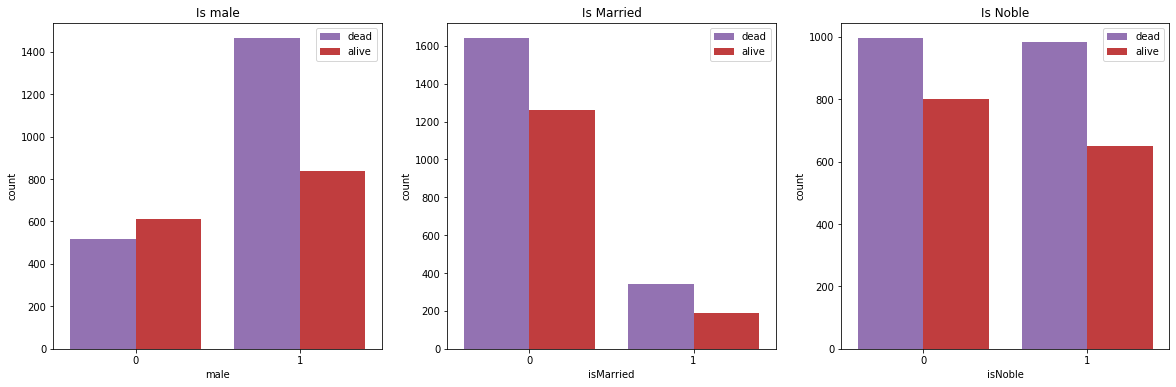

In [12]:
import matplotlib as plt
import seaborn as sns
%pylab inline

# бинарные признаки
fig,ax=plt.subplots(1,3,figsize=(20, 6))

sns.countplot(x = 'male', hue = target, data = full_train, palette=["C4", "C3"], ax=ax[0]).legend(labels = ["dead", "alive"])
ax[0].set_title("Is male")

sns.countplot(x = 'isMarried', hue = target, data = full_train, palette=["C4", "C3"], ax=ax[1]).legend(labels = ["dead", "alive"])
ax[1].set_title("Is Married")

sns.countplot(x = 'isNoble', hue = target, data = full_train, palette=["C4", "C3"], ax=ax[2]).legend(labels = ["dead", "alive"])
ax[2].set_title("Is Noble")

Text(0.5, 1.0, 'book5')

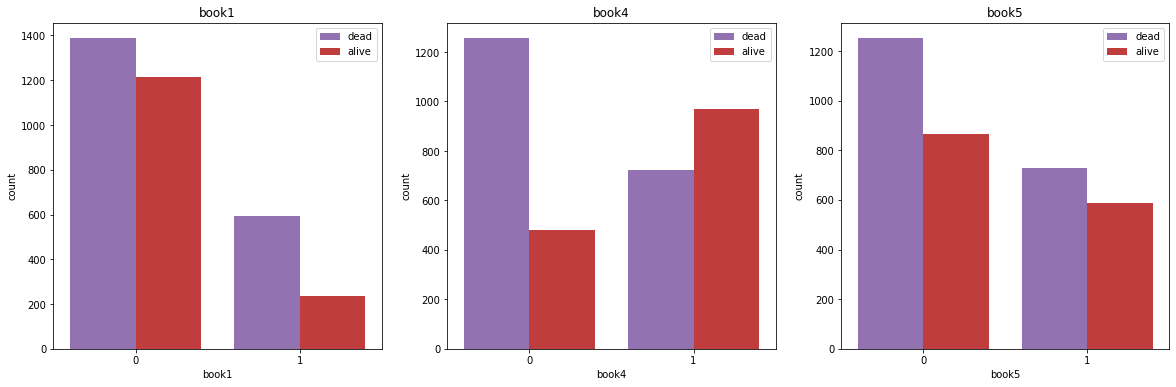

In [14]:
fig,ax=plt.subplots(1,3,figsize=(20, 6))

sns.countplot(x = 'book1', hue = target, data = full_train, palette=["C4", "C3"], ax=ax[0]).legend(labels = ["dead", "alive"])
ax[0].set_title("book1")

sns.countplot(x = 'book4', hue = target, data = full_train, palette=["C4", "C3"], ax=ax[1]).legend(labels = ["dead", "alive"])
ax[1].set_title("book4")

sns.countplot(x = 'book5', hue = target, data = full_train, palette=["C4", "C3"], ax=ax[2]).legend(labels = ["dead", "alive"])
ax[2].set_title("book5")

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


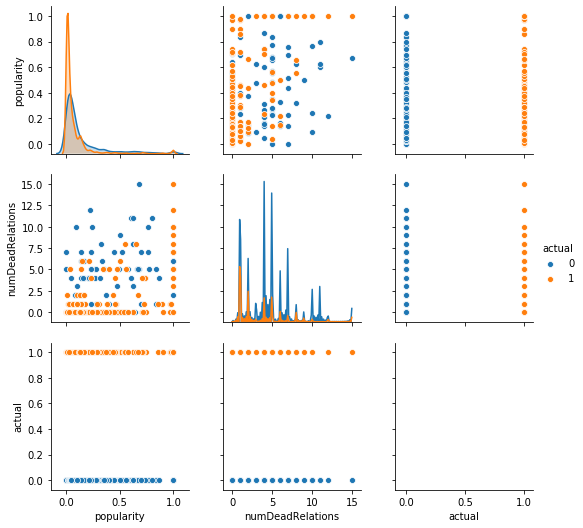

In [15]:
sns.pairplot(train[feats_real+['actual']], hue='actual')

## Модель

In [17]:
from sklearn.model_selection import train_test_split
full_train. drop('name', axis=1, inplace=True)
X_train, X_test, y_train, y_test=train_test_split(full_train, target, test_size=0.2)

In [24]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(C=0.001)
lr.fit(X_train, y_train)
pred=lr.predict(X_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [25]:
from sklearn.metrics import f1_score, accuracy_score
print('f1_score: ' + str(f1_score(y_test, pred)))
print('accuracy: '+ str(accuracy_score(y_test, pred)))

f1_score: 0.47596153846153844
accuracy: 0.6826783114992722


Text(0.5, 1.05, 'Confusion_matrix for RF')

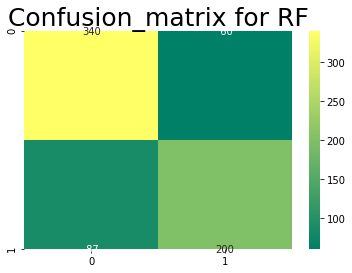

In [20]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=25)

In [21]:
confusion_matrix(y_test, pred)

array([[340,  60],
       [ 87, 200]], dtype=int64)